<h1> Houston, TX Total Population Data x Houston, TX Gun Violence Data
    

We are looking into the correlation between the geolocation of Houston (and its pop.) to the gun violence data reported in that same area. We wish to compare our findings here with the existing data analysis we have accumulated from education and income too.

import libraries to read/wrangle data, create spacial data, create basemaps, for spatial statistics, and graphics

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


import huston total pop, data

In [2]:
gdf = gpd.read_file('totalpophustonblockgroup.geojson')

show the block groups in huston using black lines

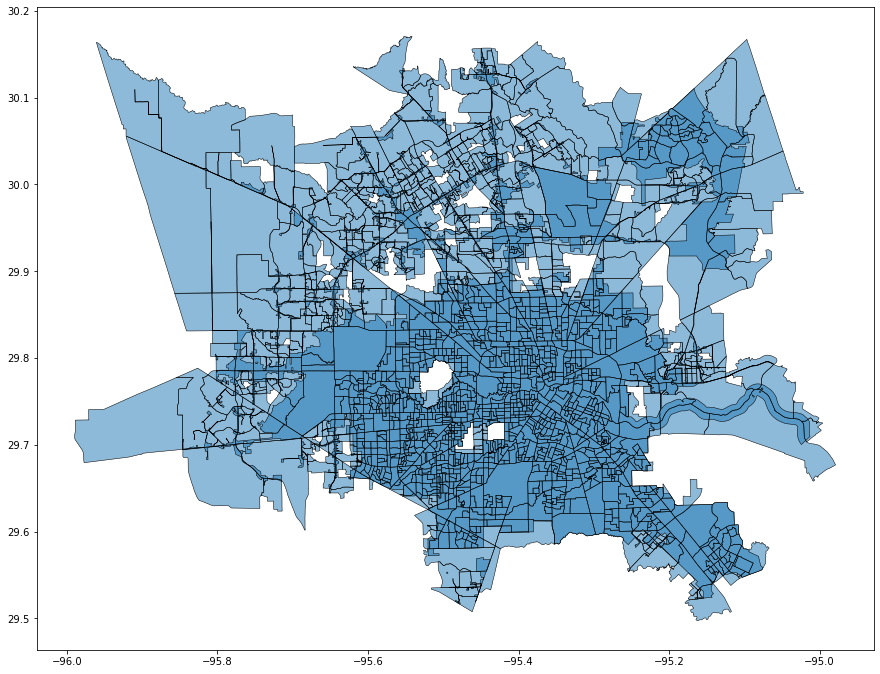

In [3]:
fig,ax = plt.subplots(figsize=(15,15))
gdf.plot(ax=ax,zorder=10,alpha=0.5)
gdf.boundary.plot(ax=ax,color='black',zorder=15,lw=0.5)

**data cleaning**

look at data types

In [4]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1863 entries, 0 to 1862
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             1863 non-null   object  
 1   name              1863 non-null   object  
 2   B01003001         1863 non-null   float64 
 3   B01003001, Error  1863 non-null   float64 
 4   geometry          1863 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 72.9+ KB


look at what columns we are working with

In [5]:
list(gdf)

['geoid', 'name', 'B01003001', 'B01003001, Error', 'geometry']

trim down the columns and rename them

In [6]:
gdf = gdf[['geoid','B01003001','geometry']]
gdf.columns = ['FIPS','TotalPop','geometry']

double check if renamed

In [7]:
gdf.head()

,FIPS,TotalPop,geometry
0,15000US481576701011,1086.0,"MULTIPOLYGON (((-95.46644 29.59672, -95.46620 ..."
1,15000US481576701012,1846.0,"MULTIPOLYGON (((-95.46828 29.59301, -95.46756 ..."
2,15000US481576701013,3190.0,"MULTIPOLYGON (((-95.45709 29.58659, -95.45672 ..."
3,15000US481576701014,511.0,"MULTIPOLYGON (((-95.46339 29.59427, -95.46324 ..."
4,15000US481576701021,2272.0,"MULTIPOLYGON (((-95.47123 29.58615, -95.47120 ..."


figure out what the last column is bc it is the total pop. of the city and it must be deleted

In [8]:
gdf.tail()

,FIPS,TotalPop,geometry
1858,15000US483396920022,8696.0,"MULTIPOLYGON (((-95.40544 30.09208, -95.40501 ..."
1859,15000US483396923004,2141.0,"MULTIPOLYGON (((-95.31474 30.09180, -95.31407 ..."
1860,15000US483396923005,8829.0,"MULTIPOLYGON (((-95.27522 30.09548, -95.27520 ..."
1861,15000US483396924003,6122.0,"MULTIPOLYGON (((-95.25503 30.03981, -95.25490 ..."
1862,16000US4835000,2310432.0,"MULTIPOLYGON (((-95.16953 29.80720, -95.16929 ..."


delete last row

In [9]:
gdf=gdf.drop(1862)

fix the fips code and check if it was done by checking the last few rows

In [10]:
gdf['FIPS'] = gdf['FIPS'].str.replace('15000US','')
gdf.tail()

,FIPS,TotalPop,geometry
1857,483396920021,6373.0,"MULTIPOLYGON (((-95.37754 30.11889, -95.37490 ..."
1858,483396920022,8696.0,"MULTIPOLYGON (((-95.40544 30.09208, -95.40501 ..."
1859,483396923004,2141.0,"MULTIPOLYGON (((-95.31474 30.09180, -95.31407 ..."
1860,483396923005,8829.0,"MULTIPOLYGON (((-95.27522 30.09548, -95.27520 ..."
1861,483396924003,6122.0,"MULTIPOLYGON (((-95.25503 30.03981, -95.25490 ..."


sort data by total population and then list the first 20 rows

In [11]:
gdf.sort_values(by='TotalPop').head(20)

,FIPS,TotalPop,geometry
1517,482015323002,0.0,"MULTIPOLYGON (((-95.52454 29.86555, -95.52409 ..."
1840,482019800001,4.0,"MULTIPOLYGON (((-95.28884 29.63928, -95.28882 ..."
798,482014103001,93.0,"MULTIPOLYGON (((-95.40883 29.76061, -95.40863 ..."
546,482013140011,103.0,"MULTIPOLYGON (((-95.40211 29.70140, -95.40090 ..."
253,482012322002,125.0,"MULTIPOLYGON (((-95.29556 29.91871, -95.29553 ..."
361,482012504022,201.0,"MULTIPOLYGON (((-95.16227 29.99858, -95.16209 ..."
1115,482014328024,204.0,"MULTIPOLYGON (((-95.52133 29.70898, -95.52132 ..."
115,482012123003,216.0,"MULTIPOLYGON (((-95.36665 29.77396, -95.36644 ..."
1767,482015532004,233.0,"MULTIPOLYGON (((-95.44941 30.02490, -95.44880 ..."
427,482012524003,245.0,"MULTIPOLYGON (((-95.15569 29.77374, -95.15554 ..."


delete rows that have less than a 100 population geographies

In [12]:
gdf = gdf[gdf['TotalPop']>100]

**Map the new map**

get the layers into a web mercator projection and reproject to web mercator

In [13]:
gdf = gdf.to_crs(epsg=3857)

plot. turn off the axis, and add a base map

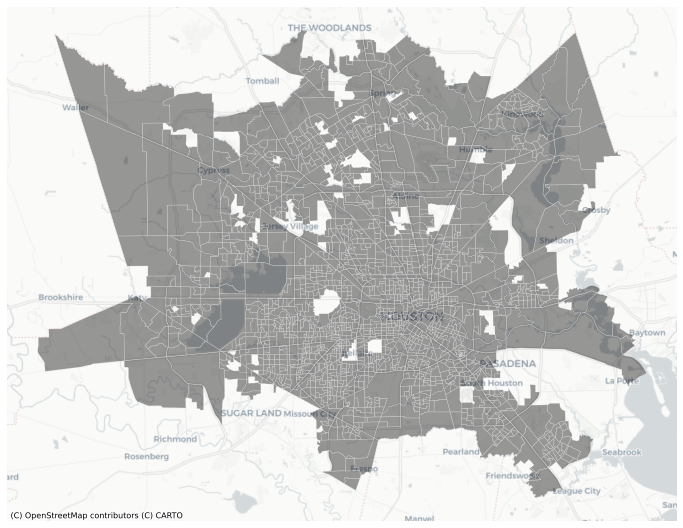

In [14]:
fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)
ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**now let's introduce our second data set**

import gun violence dataset


In [15]:
gdf2= gpd.read_file('GVDNEW.csv')

look at data we are dealing with 

In [16]:
gdf2.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,geometry
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,,,None
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62,35,None
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56,13,None
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40,28,None
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62,27,None


list out the column names of gdf2

In [17]:
list(gdf2)

['incident_id',
 'date',
 'state',
 'city_or_county',
 'address',
 'n_killed',
 'n_injured',
 'incident_url',
 'source_url',
 'incident_url_fields_missing',
 'congressional_district',
 'gun_stolen',
 'gun_type',
 'incident_characteristics',
 'latitude',
 'location_description',
 'longitude',
 'n_guns_involved',
 'notes',
 'participant_age',
 'participant_age_group',
 'participant_gender',
 'participant_name',
 'participant_relationship',
 'participant_status',
 'participant_type',
 'sources',
 'state_house_district',
 'state_senate_district',
 'geometry']

trim down columns and rename them

In [18]:
gdf2 = gdf2[[
 'state',
 'city_or_county',
 'address',
 'latitude',
 'longitude']]

check if trimed/renamed

In [19]:
gdf2.head()

,state,city_or_county,address,latitude,longitude
0,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,40.3467,-79.8559
1,California,Hawthorne,13500 block of Cerise Avenue,33.909,-118.333
2,Ohio,Lorain,1776 East 28th Street,41.4455,-82.1377
3,Colorado,Aurora,16000 block of East Ithaca Place,39.6518,-104.802
4,North Carolina,Greensboro,307 Mourning Dove Terrace,36.114,-79.9569


create a new dataframe that holds only data of huston by using a query

In [20]:
gdf3 = gdf2[gdf2.city_or_county == 'Houston']

check if its only huston

In [21]:
gdf3

,state,city_or_county,address,latitude,longitude
102,Texas,Houston,9780 Bissonnet,29.6754,-95.5499
243,Texas,Houston,4400 block of Tiffany,29.6168,-95.4428
244,Texas,Houston,8200 block of Sunbury,29.8222,-95.2761
309,Texas,Houston,,29.7654,-95.3663
612,Texas,Houston,Ojeman Road at Hammerly Boulevard,29.8109,-95.5024
...,...,...,...,...,...
175841,Texas,Houston,3520 Old Spanish Trail,29.7019,-95.3664
175945,Texas,Houston,4328 W Fuqua St,29.6135,-95.4422
176189,Texas,Houston,,29.7654,-95.3663
176200,Texas,Houston,13350 Almeda Rd,29.614,-95.42


condense cells further to just longitude and latitude and then check

In [22]:
gdf3 = gdf3[[
 'latitude',
 'longitude']]

In [23]:
gdf3

,latitude,longitude
102,29.6754,-95.5499
243,29.6168,-95.4428
244,29.8222,-95.2761
309,29.7654,-95.3663
612,29.8109,-95.5024
...,...,...
175841,29.7019,-95.3664
175945,29.6135,-95.4422
176189,29.7654,-95.3663
176200,29.614,-95.42


novert the pandas strings data type of the long. and lat. to floats 

In [24]:
gdf3['latitude'] = pd.to_numeric(gdf3['latitude'],errors='coerce')
gdf3['longitude'] = pd.to_numeric(gdf3['longitude'],errors='coerce')

<ipython-input-24-c0558a8917f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf3['latitude'] = pd.to_numeric(gdf3['latitude'],errors='coerce')
<ipython-input-24-c0558a8917f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf3['longitude'] = pd.to_numeric(gdf3['longitude'],errors='coerce')


check if data type has changed

In [25]:
gdf3['latitude'].dtypes

dtype('float64')

In [26]:
gdf3['longitude'].dtypes

dtype('float64')

convert from pandas to geopandas dataframe

In [27]:
gdf3 = gpd.GeoDataFrame(gdf3, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(gdf3.longitude, gdf3.latitude))

project data onto a mercator map

In [28]:
gdf3 = gdf3.to_crs(epsg=3857)

now map it and add arguments to have no axis and to add a basemap

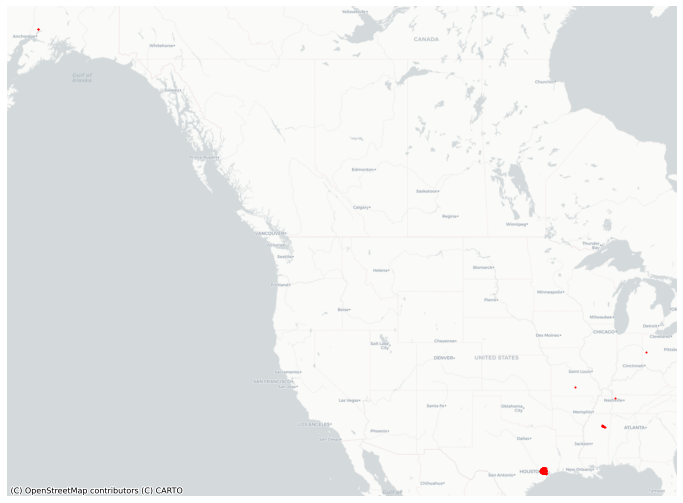

In [29]:
fig,ax = plt.subplots(figsize=(12,12))

gdf3.plot(ax=ax,
             color='red',
             markersize=1)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


now look for the bounds of Houston

In [30]:
minx, miny, maxx, maxy = gdf.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-10685533.430958357
-10572996.661533259
3439099.720253502
3525498.55837201


now we set up a plot canvas using plt.subplots. we plot the huston block groups and huston gun violence data (both in the same ax plot overlapping). we use the bounding box coodinates from earlier to set the x and y limits and add an agrument to create a margin around the total bounds. finally, no axis and add basemap.

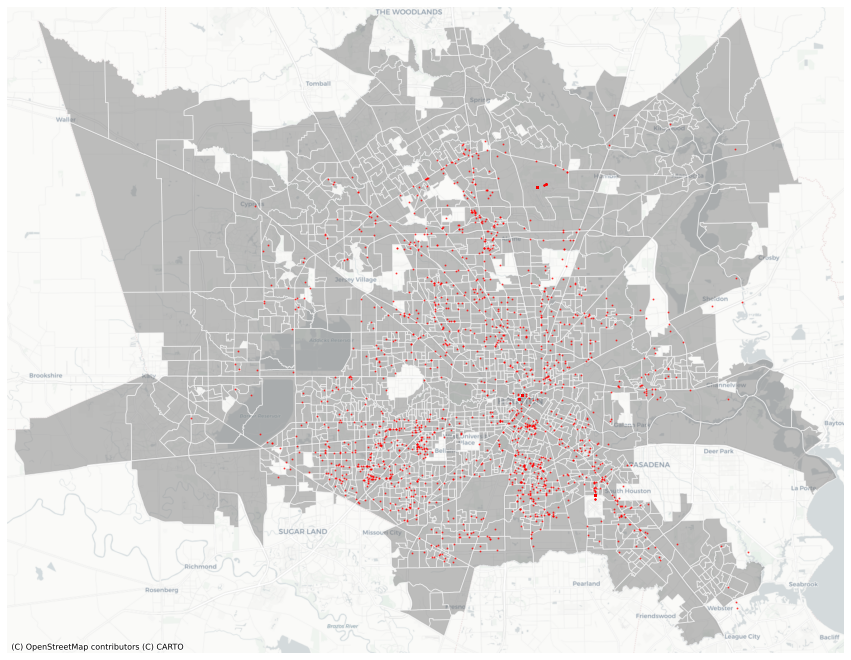

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

gdf3.plot(ax=ax,
            color='red',
            markersize=1,
            alpha=0.6)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now we will be doing a spatial join of the Houston population data and the gun violence data. We will be attaching the gun violence data to the population data

In [32]:
join = gpd.sjoin(gdf3, gdf, how='left')
join.head()

,latitude,longitude,geometry,index_right,FIPS,TotalPop
102,29.6754,-95.5499,POINT (-10636566.213 3461893.407),1141.0,482014335012,2422.0
243,29.6168,-95.4428,POINT (-10624643.896 3454387.546),622.0,482013306004,2855.0
244,29.8222,-95.2761,POINT (-10606086.937 3480715.724),225.0,482012309003,651.0
309,29.7654,-95.3663,POINT (-10616127.955 3473429.705),60.0,482011000003,1461.0
612,29.8109,-95.5024,POINT (-10631278.538 3479265.887),1408.0,482015212001,2412.0


this counts gun violence rates by their corresponding block group in the pop. data

In [33]:
gdf3_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='gdf3_count')

print to check

In [34]:
gdf3_by_gdf.head()

,FIPS,gdf3_count
0,482019801001,194
1,482011000003,133
2,482013320001,10
3,482014213002,10
4,482013311004,9


this is a barchart of the top 20 block groups with the largest amount of gun violence incidents

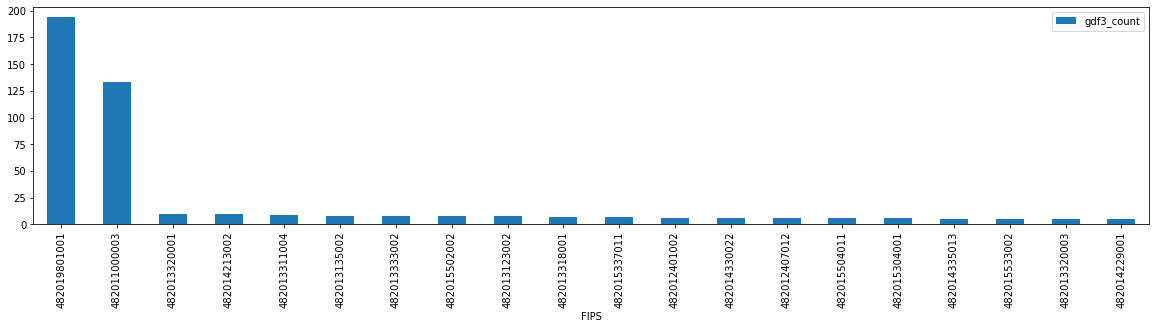

In [35]:
gdf3_by_gdf[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='gdf3_count')

now we will join the summary table back to the pop. data

In [36]:
gdf=gdf.merge(gdf3_by_gdf,on='FIPS')

now check

In [37]:
gdf.head()

,FIPS,TotalPop,geometry,gdf3_count
0,481576701011,1086.0,"MULTIPOLYGON (((-10627274.932 3451816.449, -10...",1
1,481576701012,1846.0,"MULTIPOLYGON (((-10627480.762 3451341.746, -10...",2
2,481576701013,3190.0,"MULTIPOLYGON (((-10626234.429 3450519.251, -10...",2
3,481576701014,511.0,"MULTIPOLYGON (((-10626936.409 3451503.435, -10...",1
4,481576702003,1330.0,"MULTIPOLYGON (((-10628171.833 3451193.501, -10...",2


normalize the data and add a new column

In [38]:
gdf['gdf3_per_1000'] = gdf['gdf3_count']/gdf['TotalPop']*1000

check the last rows

In [39]:
gdf.sort_values(by="gdf3_per_1000").tail()

,FIPS,TotalPop,geometry,gdf3_count,gdf3_per_1000
197,482013123002,834.0,"MULTIPOLYGON (((-10615785.536 3469340.954, -10...",8,9.592326
471,482014328024,204.0,"MULTIPOLYGON (((-10633386.261 3466196.390, -10...",2,9.803922
195,482013122003,479.0,"MULTIPOLYGON (((-10615218.920 3468945.086, -10...",5,10.438413
14,482011000003,1461.0,"MULTIPOLYGON (((-10616946.710 3472762.112, -10...",133,91.033539
759,482019801001,519.0,"MULTIPOLYGON (((-10617664.164 3506168.743, -10...",194,373.795761


set k=8 to account for surrounding neighbors to determine the spatial weight of gun violence in houston then we do row standardization to adjust the nearest neighbor weight in a spatial weight matrix

In [40]:
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)
wq.transform = 'r'

We will now be creating a new column for the average of the “r” value to create a single value

In [41]:
gdf['gdf3_per_1000_lag'] = lps.weights.lag_spatial(wq, gdf['gdf3_per_1000'])

now check the edits

In [42]:
gdf.sample(10)[['TotalPop','gdf3_count','gdf3_per_1000','gdf3_per_1000_lag']]

,TotalPop,gdf3_count,gdf3_per_1000,gdf3_per_1000_lag
111,1767.0,2,1.131862,1.176740
30,1458.0,2,1.371742,2.080849
706,4585.0,1,0.218103,0.557299
78,2944.0,2,0.679348,1.419374
531,2606.0,1,0.383730,0.489077
226,1134.0,4,3.527337,2.648846
382,3200.0,10,3.125000,1.047894
403,1926.0,3,1.557632,1.899439
88,308.0,1,3.246753,1.465824
344,1645.0,1,0.607903,1.676446


create new column that calculates the difference between gun violence data and spatial lag

In [43]:
gdf['gdf3_lag_diff'] = gdf['gdf3_per_1000'] - gdf['gdf3_per_1000_lag']

check the first and last 5 rows

In [44]:
gdf.sort_values(by='gdf3_lag_diff')

,FIPS,TotalPop,geometry,gdf3_count,gdf3_per_1000,gdf3_per_1000_lag,gdf3_lag_diff
152,482012409012,7439.0,"MULTIPOLYGON (((-10610833.155 3507818.237, -10...",1,0.134427,47.285444,-47.151017
151,482012409011,3960.0,"MULTIPOLYGON (((-10612099.302 3505045.631, -10...",1,0.252525,47.203278,-46.950752
155,482012511005,2534.0,"MULTIPOLYGON (((-10604714.367 3507719.613, -10...",1,0.394633,47.308152,-46.913519
760,483396923004,2141.0,"MULTIPOLYGON (((-10610388.322 3515355.730, -10...",1,0.467071,47.229808,-46.762737
141,482012404001,3675.0,"MULTIPOLYGON (((-10620411.640 3506356.838, -10...",2,0.544218,47.282329,-46.738111
...,...,...,...,...,...,...,...
219,482013135002,961.0,"MULTIPOLYGON (((-10614709.188 3463700.334, -10...",8,8.324662,1.647492,6.677170
195,482013122003,479.0,"MULTIPOLYGON (((-10615218.920 3468945.086, -10...",5,10.438413,3.490421,6.947993
471,482014328024,204.0,"MULTIPOLYGON (((-10633386.261 3466196.390, -10...",2,9.803922,0.831125,8.972796
14,482011000003,1461.0,"MULTIPOLYGON (((-10616946.710 3472762.112, -10...",133,91.033539,1.615401,89.418138


**Moran Plot**

now we will quantify the degree of the spatial correlations

In [45]:
y = gdf.gdf3_per_1000
moran = Moran(y, wq)
moran.I

-0.0031459946560232818

it seems that we have a negative spatial autocorrelation, meaning that it is less common and that similar value a quite far from each other (aka "high values are next to low values, low values are next to high values")

now we output a scatter plot of our "gun violence data per 1000" and "gun violence data per 1000 spatial lag" in Houston

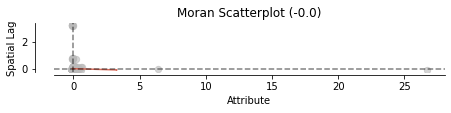

In [46]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

we will now compare our observed Moran’s I value to this reference distribution

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4854576760>)

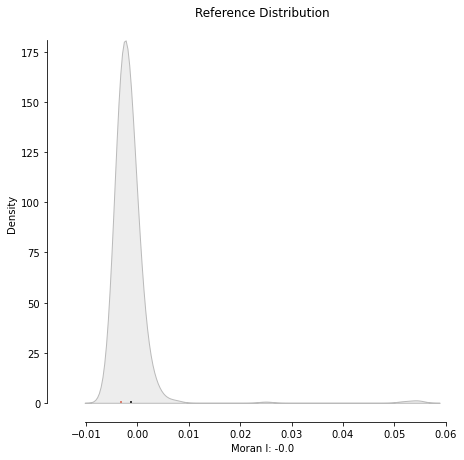

In [47]:
plot_moran_simulation(moran,aspect_equal=False)

now we get the p-value

In [48]:
 moran.p_sim

0.284

calculate local moran values

In [49]:
lisa = esda.moran.Moran_Local(y, wq)

now we plot and add some arguments for the labelz for our moran local scatterplot. using lisa to detect clusters for the correlation in neighborhood quality and our gun data, we can discern the high values near to high values (HH), low values with nearby low values (LL), low values with high values in its neighborhood (& vice-versa)

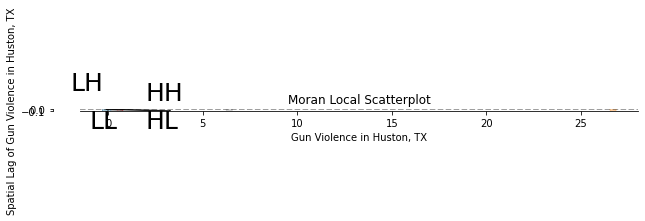

In [50]:
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Gun Violence in Huston, TX")
ax.set_ylabel('Spatial Lag of Gun Violence in Huston, TX')

plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

judging by the visualization, and the lack of clusters, there is not much of a correlation

**Spatial Autocorrelation Map**


using the lisa_cluster function we can vizualize the clusters

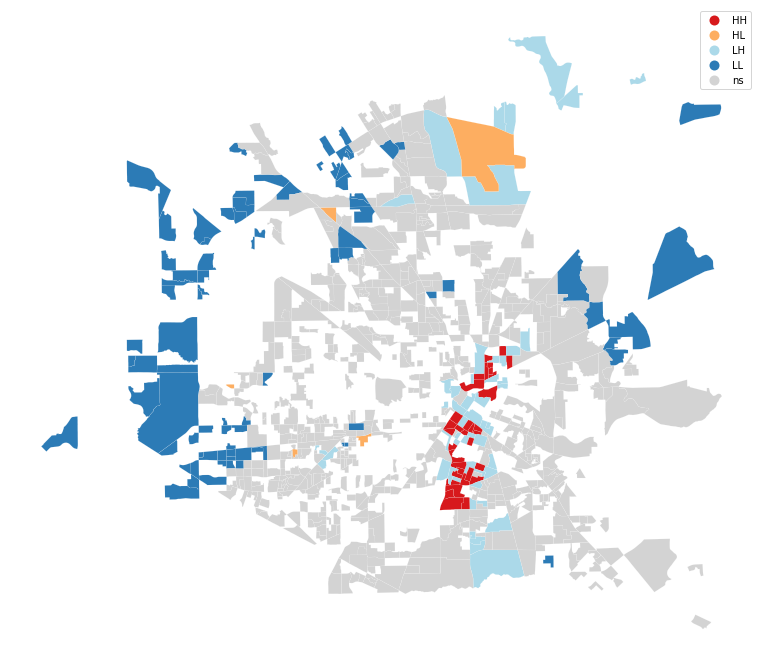

In [51]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf, p=0.05, ax=ax)
plt.show()

We have been led to believe that we don't have a great degree of spatial correlation, based off of the Moran plot. Yet, when we look at the Spatial Autocorrelation Map we notice that it is registering some clusters. 

We are left wondering if our data requires further cleaning of some sort, and if we are experiencing a problem comprable to that of the "0,0 Conundrum" 

However, a low correlation is not surprising given that the city of houston is heavily populated by people with high incomes and high educational attainments, meaning that is is a rather affluent area that does not experience large amounts of gun violence. 

Stacy got the houston pop data and Ainsleigh got the new gun violence data.We both worked on it for the most part via zoom.